In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
class FfAgentContinuous(object):
    def __init__(self, session, input_size, output_size, gamma=0.99):
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        
        self.observations_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.input_size])
        # esdr = expected sum of discounted rewards
        self.esdr_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        self.v_s_ph  = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s)
        self.v_sp_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s')
        self.r_ph    = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # r_t+1; r'
        self.actions_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.output_size])
        #self.reward_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        
        advantage = self.esdr_ph - self.v_s_ph
        mean_adv = tf.reduce_mean(advantage)
        stddev_adv = tf.sqrt(tf.reduce_mean(advantage*advantage) - mean_adv*mean_adv)
        self.adv_normalized = (advantage - mean_adv)/(stddev_adv + 1e-8)

        l2_policy_means, l2_policy_stdevs = self.buildActor("policy_new")
        l2_policy_means_prev, l2_policy_stdevs_prev = self.buildActor("policy_old", trainable=False)
            
        W1v = tf.get_variable("w1v", [self.input_size, 128], initializer=tf.initializers.random_normal(stddev=0.01))
        b1v = tf.get_variable("b1v", [128], initializer=tf.initializers.random_normal(stddev=0.01))
        W2v = tf.get_variable("w2v", [128, 1], initializer=tf.initializers.random_normal(stddev=0.01)) # value
        b2v = tf.get_variable("b2v", [1], initializer=tf.initializers.random_normal(stddev=0.01))
        
        l1v = tf.nn.relu(tf.matmul(self.observations_ph, W1v) + b1v)
        l2v = tf.matmul(l1v, W2v) + b2v

        actor_ratio_numerator = (1/l2_policy_stdevs)*tf.exp(
            -0.5*tf.square(
                (l2_policy_means - self.actions_ph)/l2_policy_stdevs
            )
        )
        actor_ratio_denominator = (1/l2_policy_stdevs_prev)*tf.exp(
            -0.5*tf.square(
                (l2_policy_means_prev - self.actions_ph)/l2_policy_stdevs_prev
            )
        )
        actor_ratio = actor_ratio_numerator/actor_ratio_denominator
        self.actor_loss = -1.0*tf.reduce_mean(
            tf.minimum(
                actor_ratio*advantage,
                advantage*tf.clip_by_value(actor_ratio, 1 - 0.2, 1 + 0.2))
        )
        self.actor_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.actor_loss)
        #optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        #grads_and_vars = optimizer.compute_gradients(self.actor_loss)
        #capped_grads = [(grad if grad is None else tf.clip_by_norm(grad, 2.0), var) for grad, var in grads_and_vars]
        #self.actor_optimizer = optimizer.apply_gradients(capped_grads)
        
        self.critic_loss = tf.reduce_mean(
            tf.square(l2v - self.esdr_ph)
        )
        self.critic_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.critic_loss)
        
        self.action_prediction_means = l2_policy_means
        self.action_prediction_stdevs = l2_policy_stdevs
        self.esdr_predictions = l2v
        
    def updatePrevActor(self):
        old_params = [v for v in tf.global_variables() if "policy_old" in v.name]
        new_params = [v for v in tf.global_variables() if "policy_new" in v.name]
        
        assignments = [op.assign(np) for op, np in zip(old_params, new_params)]
        self.session.run(assignments)
        
    def buildActor(self, scope_name, reuse_scope=False, trainable=True):
        with tf.variable_scope(scope_name, reuse=reuse_scope):
            W1p = tf.get_variable(
                "w1p",
                [self.input_size, 128],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable
            )
            b1p = tf.get_variable(
                "b1p",
                [128],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable
            )
            W2p_means = tf.get_variable(
                "w2pmeans",
                [128, self.output_size],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable                
            )
            W2p_stdevs = tf.get_variable(
                "w2pstdevs",
                [128, self.output_size],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable
            )
            b2p_means = tf.get_variable(
                "b2pmeans",
                [self.output_size],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable
            )
            b2p_stdevs = tf.get_variable(
                "b2pstdevs",
                [self.output_size],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable
            )

            l1p = tf.nn.relu(tf.matmul(self.observations_ph, W1p) + b1p)
            # this will need to be changed to accommodate the range and character of action values
            l2p_means = tf.matmul(l1p, W2p_means) + b2p_means
            # Trying to start with a large standard deviation to encourage exploration early on.
            l2p_stdevs = tf.matmul(l1p, W2p_stdevs) + b2p_stdevs + 7
            l2_policy_means = 2*tf.nn.tanh(l2p_means)
            l2_policy_stdevs = tf.math.minimum(tf.nn.softplus(l2p_stdevs), 10) + 0.00001
            #l2_policy_stdevs = tf.nn.softplus(l2p_stdevs)
            
            return l2_policy_means, l2_policy_stdevs
        
    # For advantage:
    #    Add single timestep reward samples
    #    Add placeholders for estimated V(s) and V(s')
    def trainSarBatches(self, states, actions, discounted_rewards):
        '''
        Expects inputs to be numpy arrays of shape:
            states = [batch_size, num_state_features]
            actions = [batch_size, num_available_actions]
            discounted_rewards = [batch_size, 1]
        
        The idea is that all episodes have been parsed through and shuffled into
        one big batch of training data.
        '''
        
        advantage_feeds = {
            self.observations_ph: states
        }
        #print("shape of discounted rewards:", discounted_rewards.shape)
        
        advantage_fetches = self.esdr_predictions
        
        v_predictions = self.session.run(advantage_fetches, feed_dict=advantage_feeds)
        #print(v_predictions.shape)
        
        optimize_feeds = {
            self.observations_ph: states,
            self.esdr_ph: discounted_rewards,
            self.v_s_ph: v_predictions,
            self.actions_ph: actions
        }
        
        optimize_fetches = [
            #self.reinforce_loss,
            self.actor_loss,
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions,
            #self.reinforce_optimizer
            #self.actor_critic_optimizer
            self.actor_optimizer,
            self.critic_optimizer
        ]
        
        loss, action_prediction_means, action_prediction_stdevs, esdr_predictions, _1, _2 = \
            self.session.run(optimize_fetches, feed_dict=optimize_feeds)
        
        return loss, action_prediction_means, action_prediction_stdevs, esdr_predictions
    
    def predict(self, state):
        '''
        Expects state to have the shape [num_state_features]
        '''
        
        feeds = {
            self.observations_ph: np.array([state])
        }
        #print("state received by agent:", state)
        fetches = [
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions
        ]
        action_prediction_means, action_prediction_stdevs, esdr_predictions = self.session.run(fetches, feed_dict=feeds)
        return action_prediction_means, action_prediction_stdevs, esdr_predictions

In [3]:
def prepSarData(states, actions, rewards, gamma=0.99):
    '''
    Converts temporally synced lists of states, actions, and rewards into shuffled
    numpy matrices for training.
    '''
    #print(len(states), len(actions), len(rewards))
    discounted_sum_rewards = 0
    discounted_rewards = []
    for i in range(len(rewards) - 1, -1, -1):
        discounted_sum_rewards = gamma*discounted_sum_rewards + rewards[i]
        discounted_rewards.append(discounted_sum_rewards)
    discounted_rewards = np.expand_dims(np.array(discounted_rewards[::-1]), axis=1)
    
    actions = np.array(actions)
    states = np.array(states)
    indices = [i for i in range(len(actions))]
    np.random.shuffle(indices)
    
    actions_shuffled = actions[indices]
    states_shuffled = states[indices]
    discounted_rewards_shuffled = discounted_rewards[indices]
    
    return actions_shuffled, states_shuffled, discounted_rewards_shuffled

In [4]:
def accumulateData(env, agent, max_steps=1000, max_rollouts=50):
    states = []
    actions = []
    rewards = []
    for rollout_count in range(max_rollouts):
        ep_states = []
        ep_actions = []
        ep_rewards = []
        ep_state_t = env.reset()
        ep_states.append(ep_state_t)
        for t in range(max_steps):
            ep_action_t = np.random.normal(loc=agent.predict(ep_state_t)[0][0], scale=agent.predict(ep_state_t)[1][0])
            #print(ep_action_t)
            ep_action_t = min(max(ep_action_t, [-2.0]), [2.0])
            #print(ep_action_t)
            ep_state_tp1, ep_reward_tp1, done, _ = env.step(ep_action_t)

            ep_actions.append(ep_action_t)
            ep_states.append(ep_state_tp1)
            ep_rewards.append(ep_reward_tp1)
            if done:
                ep_states.pop(-1)
                #ep_rewards.pop(-1)
                break
            ep_state_t = ep_state_tp1
        states.append(ep_states)
        actions.append(ep_actions)
        rewards.append(ep_rewards)
    return states, actions, rewards

In [5]:
def renderAgent(env, agent):
    state_t = env.reset()
    rewards = 0
    actions = []
    while i < 1000:
        action_t = np.random.normal(loc=agent.predict(state_t)[0][0], scale=agent.predict(state_t)[1][0])
        #print(ep_action_t)
        action_t = min(max(action_t, [-2.0]), [2.0])
        actions.append(action_t)
        #print(ep_action_t)
        state_tp1, reward_tp1, done, _ = env.step(action_t)
        rewards += reward_tp1
        env.render()
        state_t = state_tp1
        if done:
            print("Rewards from rendering:", rewards)
            break
    return actions

In [6]:
#print(type(gym.envs.registry.all()))
env_ids = [espec.id for espec in gym.envs.registry.all()]
for e in sorted(env_ids):
    print(e)


Acrobot-v1
AirRaid-ram-v0
AirRaid-ram-v4
AirRaid-ramDeterministic-v0
AirRaid-ramDeterministic-v4
AirRaid-ramNoFrameskip-v0
AirRaid-ramNoFrameskip-v4
AirRaid-v0
AirRaid-v4
AirRaidDeterministic-v0
AirRaidDeterministic-v4
AirRaidNoFrameskip-v0
AirRaidNoFrameskip-v4
Alien-ram-v0
Alien-ram-v4
Alien-ramDeterministic-v0
Alien-ramDeterministic-v4
Alien-ramNoFrameskip-v0
Alien-ramNoFrameskip-v4
Alien-v0
Alien-v4
AlienDeterministic-v0
AlienDeterministic-v4
AlienNoFrameskip-v0
AlienNoFrameskip-v4
Amidar-ram-v0
Amidar-ram-v4
Amidar-ramDeterministic-v0
Amidar-ramDeterministic-v4
Amidar-ramNoFrameskip-v0
Amidar-ramNoFrameskip-v4
Amidar-v0
Amidar-v4
AmidarDeterministic-v0
AmidarDeterministic-v4
AmidarNoFrameskip-v0
AmidarNoFrameskip-v4
Ant-v2
Assault-ram-v0
Assault-ram-v4
Assault-ramDeterministic-v0
Assault-ramDeterministic-v4
Assault-ramNoFrameskip-v0
Assault-ramNoFrameskip-v4
Assault-v0
Assault-v4
AssaultDeterministic-v0
AssaultDeterministic-v4
AssaultNoFrameskip-v0
AssaultNoFrameskip-v4
Asterix-ra

In [7]:
pendulum = gym.make("Pendulum-v0")
session = tf.Session()
print(pendulum.observation_space.shape)
print(pendulum.action_space)
num_actions = len(pendulum.action_space.high)
agent = FfAgentContinuous(session, pendulum.observation_space.shape[0], num_actions)

session.run(tf.global_variables_initializer())

/home/jg/.local/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(3,)
Box(1,)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0
average reward:  -1250.0734457734052 stdevs: 1.4217758 losses: -22757678.0
1
average reward:  -1318.3620015530032 stdevs: 0.028145473 losses: -353.32312
2
average reward:  -1317.3362832423663 stdevs: 0.13606542 losses: -173.1803
3
average reward:  -1319.693290962972 stdevs: 2.198155e-05 losses: -150.17229
4
average reward:  -1329.0989732347523 stdevs: 3.7468586 losses: -9.724163
5
average reward:  -1305.8502539386534 stdevs: 1.0127181e-05 losses: -59.806602
6
average reward:  -1300.2470123723326 stdevs: 3.9278338 losses: -17.813457
7
average reward:  -1307.770217259976 stdevs: 0.66345894 losses: -8.997187
8
average reward:  -1327.829664864651 stdevs: 1.08473505e-05 losses: -25.798689
9
average reward:  -1305.099970530577 stdevs: 0.00076654146 losses: -44.288887
Rewards from rendering: -1342.4911638569622


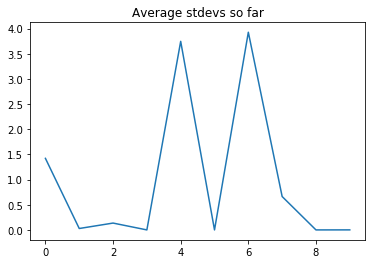

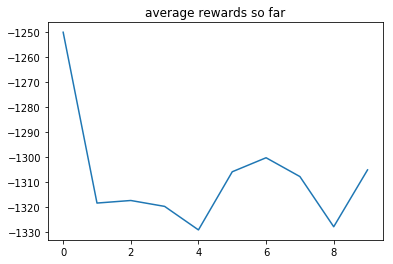

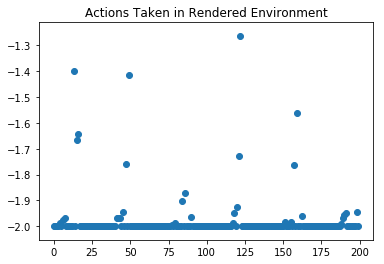

10
average reward:  -1323.0289306166005 stdevs: 0.28429088 losses: 0.9723645
11
average reward:  -1313.8875142194636 stdevs: 0.000118499396 losses: -31.438555
12
average reward:  -1328.4252970243115 stdevs: 0.15567456 losses: 15.083044
13
average reward:  -1314.7037963238147 stdevs: 0.07557737 losses: -0.6778366
14
average reward:  -1302.2418733034274 stdevs: 0.27797306 losses: 11.42306
15
average reward:  -1308.3123834382307 stdevs: 0.093815 losses: 8.6171665
16
average reward:  -1335.29361985146 stdevs: 0.0094798645 losses: -21.690468
17
average reward:  -1292.7622515866167 stdevs: 0.21876997 losses: 24.239557
18
average reward:  -1296.9071760075315 stdevs: 0.052176934 losses: 0.22219086
19
average reward:  -1308.5622607863984 stdevs: 0.34522972 losses: 19.406775
Rewards from rendering: -1180.802010408704


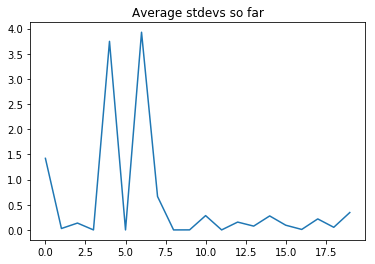

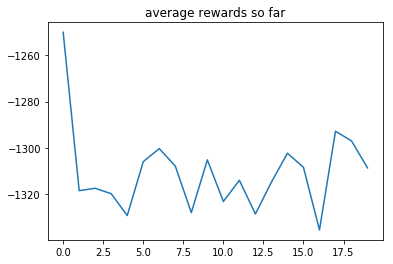

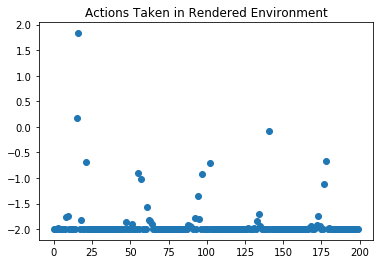

20
average reward:  -1322.236110086292 stdevs: 0.07285614 losses: 7.6843047
21
average reward:  -1340.2564902167212 stdevs: 0.13779798 losses: 6.6574903
22
average reward:  -1297.3935049511083 stdevs: 3.8775527 losses: 57.87331
23
average reward:  -1273.679689537358 stdevs: 0.026757047 losses: -21.28181
24
average reward:  -1327.1372418359895 stdevs: 0.1425826 losses: 10.824821
25
average reward:  -1346.2359849712325 stdevs: 0.0014741527 losses: -38.891445
26
average reward:  -1332.881071370623 stdevs: 0.5048776 losses: 53.89957
27
average reward:  -1312.7161646482439 stdevs: 3.898567 losses: 14.402178
28
average reward:  -1295.5062901842432 stdevs: 1.0157097e-05 losses: -51.07802
29
average reward:  -1321.875735738453 stdevs: 2.5683532e-05 losses: -47.406593
Rewards from rendering: -1489.2632782442438


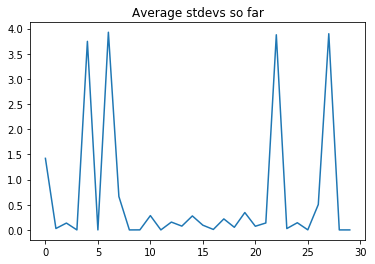

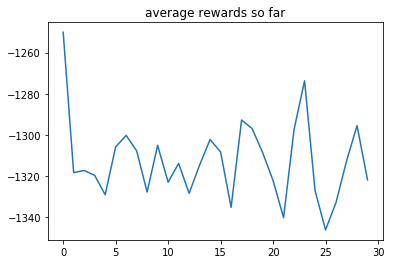

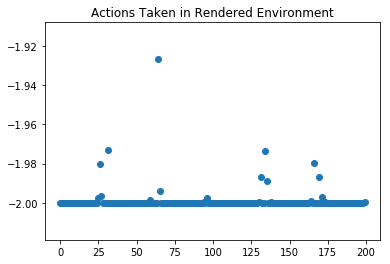

30
average reward:  -1312.0063075120704 stdevs: 0.20494469 losses: 37.701523
31
average reward:  -1307.4927020433515 stdevs: 0.03162519 losses: -14.866039
32
average reward:  -1334.7406855362992 stdevs: 0.0006233449 losses: -38.018166
33
average reward:  -1346.9635778759966 stdevs: 3.7414281 losses: -4.070787
34
average reward:  -1311.0038973886176 stdevs: 0.0007276 losses: -51.74254
35
average reward:  -1318.5508963483426 stdevs: 1.0314169e-05 losses: -41.622
36
average reward:  -1289.004715640124 stdevs: 0.050960444 losses: -9.935572
37
average reward:  -1323.049924734955 stdevs: 0.02588125 losses: -13.981258
38
average reward:  -1336.5868943518506 stdevs: 0.014185059 losses: -19.595362
39
average reward:  -1334.2947954855026 stdevs: 3.8383648 losses: -20.17438
Rewards from rendering: -1503.1486154699198


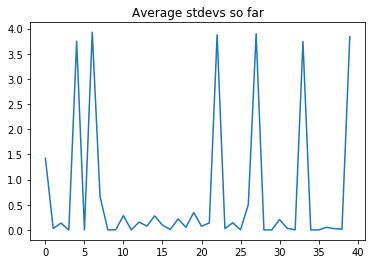

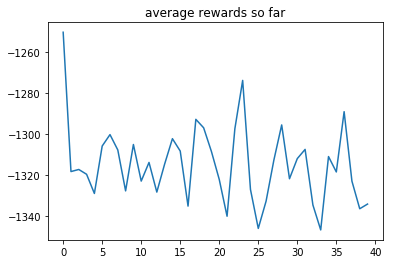

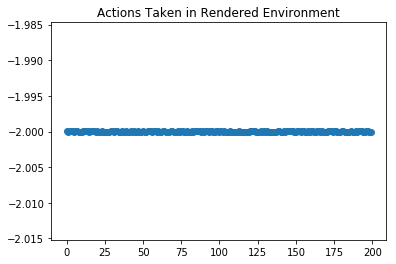

40
average reward:  -1323.5939685863784 stdevs: 0.41059875 losses: 51.047188
41
average reward:  -1285.9434180805224 stdevs: 3.913416 losses: -18.553303
42
average reward:  -1295.7302606965106 stdevs: 3.781854 losses: -9.38675
43
average reward:  -1331.0192719994716 stdevs: 0.21348628 losses: 39.032696
44
average reward:  -1318.1526492242278 stdevs: 0.02385355 losses: -17.477676
45
average reward:  -1320.3850918208313 stdevs: 3.834512 losses: -17.33953
46
average reward:  -1305.7735094702018 stdevs: 0.00036593011 losses: -56.84473
47
average reward:  -1312.8585029127007 stdevs: 0.3364035 losses: 36.104958
48
average reward:  -1316.8452912556727 stdevs: 3.7834876 losses: -8.749975
49
average reward:  -1314.4259527200772 stdevs: 1.036294e-05 losses: -42.09002
Rewards from rendering: -1282.1470762288197


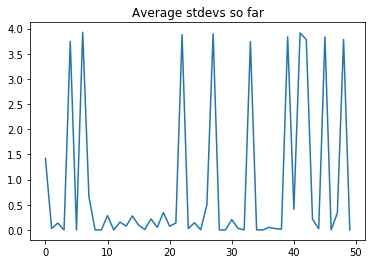

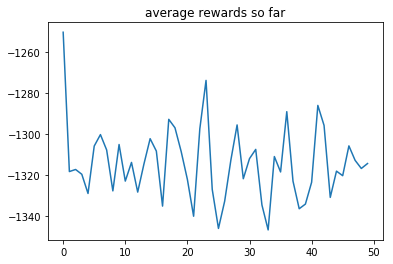

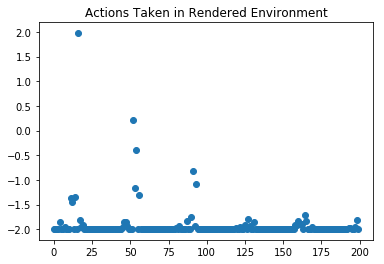

50
average reward:  -1320.7475196680614 stdevs: 3.8782828 losses: -21.590952


In [ ]:
average_rewards = []
average_stdevs = []
for i in range(10000):
    states, actions, rewards = accumulateData(pendulum, agent)
    #print(actions[0:10])
    #print(rewards[0:10])
    states_pro = []
    actions_pro = []
    rewards_pro = []
    if i % 10 == 0 and i > 0:
        
        plt.figure()
        plt.plot(average_stdevs)
        plt.title("Average stdevs so far")
        plt.figure()
        plt.plot(average_rewards)
        plt.title("average rewards so far")
        
        plottable_actions = renderAgent(pendulum, agent)
        plt.figure()
        plt.scatter(range(len(plottable_actions)), plottable_actions)
        plt.title("Actions Taken in Rendered Environment")
        plt.show()
        plt.close()
    for j in range(len(actions)):
        ret = prepSarData(actions[j], states[j], rewards[j])
        mean_reward = np.average(ret[1])
        stdev_reward = np.std(ret[1])
        states_pro.append(ret[0])
        #actions_pro.append((ret[1] - mean_reward)/stdev_reward)
        actions_pro.append(ret[1])
        rewards_pro.append(ret[2])
        #print(ret[0].shape, ret[1].shape, ret[2].shape)
        #for k in range(10):
        #    agent.trainSarBatches(ret[0], ret[1], ret[2])
    for k in range(5*len(states_pro)):
        train_index = np.random.choice(a=range(len(states_pro)))
        ret = agent.trainSarBatches(states_pro[train_index], actions_pro[train_index], rewards_pro[train_index])
        if np.isnan(ret[0]):
            print("Received nan loss, stopping training.")
            pendulum.close()
            sys.exit(-1)
    agent.updatePrevActor()
    print(i)
    average_reward = np.average([sum(r) for r in rewards])
    print("average reward: ", average_reward, "stdevs:", np.average(np.squeeze(ret[2])), "losses:", np.average(np.squeeze(ret[0])))
    average_stdevs.append(np.average(np.squeeze(ret[2])))
    average_rewards.append(average_reward)

plt.figure()
plt.plot(average_rewards)
plt.show()
pendulum.close()

In [ ]:
help(pendulum.close)

In [ ]:
help(tf.math.maximum)

In [ ]:
help(tf.sqrt)

In [ ]:
import tensorflow as tf
#help(tf.get_variable)

In [ ]:
help(tf.Variable)

In [ ]:
help(tf.variable_scope)

In [ ]:
help(tf.distributions)